In [ ]:
# # Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

# # Downloading all the required libraries


# Importing all the required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import style
from glob import glob
from natsort import natsorted
from tqdm import tqdm
from scipy.ndimage import convolve
style.use('ggplot')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Loading all the images in the drive
gt_images = []

for files in tqdm(natsorted(glob('/content/drive/My Drive/ES666CV/images/B/*'))):
    gt_images.append(cv2.imread(files, 1))

gt_images = np.array(gt_images) # Only possible because all images are of same size

100%|██████████| 6/6 [00:00<00:00, 76.82it/s]


In [ ]:
def show_image_grid(images, M, N, title='Title', figsize=8):
    # Assuming 'images' is a numpy array of shape (num_images, height, width, channels)
    if M==1:
        row_size = figsize
        col_size = figsize//4
    elif N==1:
        row_size = figsize//4
        col_size = figsize
    else:
        row_size, col_size = figsize, figsize

    fig, axes = plt.subplots(M, N, figsize=(row_size, col_size))

    if len(images.shape) < 4:
        images = np.expand_dims(images.copy(), axis=0)

    fig.suptitle(title)
    for i in range(M):
        for j in range(N):
            if M==1 and N==1:
                ax = axes
            elif M == 1 or N==1:
                ax = axes[max(i, j)]
            else:
                ax = axes[i, j]
            index = i * N + j
            if index < images.shape[0]:
                ax.imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))
            ax.axis('off')
    plt.tight_layout()
    plt.show()

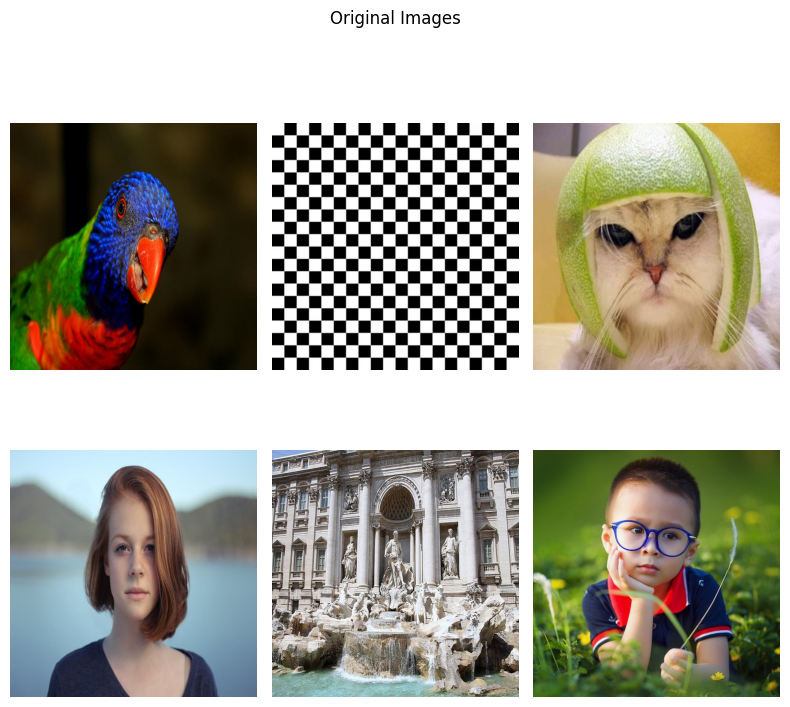

In [ ]:
show_image_grid(gt_images, 2, 3, 'Original Images', figsize=8)

Implement Gaussian Pyramid Downsampling method from scratch. Compare it with Opencv resize method. What difference do you observe when you resize an image with Gaussian Pyramid approach and Opencv approach.

References:
1. [Gaussian & Laplacian pyramid	construction](https://www.cs.toronto.edu/~mangas/teaching/320/slides/CSC320L10.pdf)
2. [Multi-Scale Representation](https://medium.com/jun94-devpblog/cv-4-multi-scale-representation-gaussian-and-laplacian-pyramid-527ca4c4831c)

In [ ]:
def pad_image_to_divisible(image, K, pad_value=0):
    # Get the original image dimensions
    h, w = image.shape[:2]

    # Calculate the padding needed for height and width
    pad_h = (K - (h % K)) % K  # Padding needed for height
    pad_w = (K - (w % K)) % K  # Padding needed for width

    # Compute the padding to add to top/bottom and left/right
    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left

    # Pad the image: (top, bottom), (left, right), and (no padding on channels)
    if len(image.shape) == 3:  # For RGB images
        padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)),
                              mode='constant', constant_values=pad_value)
    else:  # For grayscale images
        padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right)),
                              mode='constant', constant_values=pad_value)

    return padded_image

In [ ]:
def build_gaussian_pyramid(image, levels):
    pyramid = [image]
    for i in range(levels - 1):
        # Apply Gaussian Blur
        blurred = cv2.GaussianBlur(image, (5, 5), 1.0)

        # Downsample by factor of 2
        downsampled = blurred[::2, ::2]

        # Pad the image to make dimensions consistent across levels
        downsampled = pad_image_to_divisible(downsampled, pyramid[0].shape[0])

        pyramid.append(downsampled)
        image = downsampled  # Use the downsampled image for the next level
    return np.array(pyramid)


def opencv_resize(inp_image, levels):
    pyramid = []
    h, w    = inp_image.shape[:2]
    for i in range(levels):
        # Apply Gaussian blur and downsample by a factor of 2
        # Write code here
        image = cv2.resize(inp_image, (h//2**i, w//2**i))

        image = pad_image_to_divisible(image, min(h, w))
        pyramid.append(image)

    return np.array(pyramid)

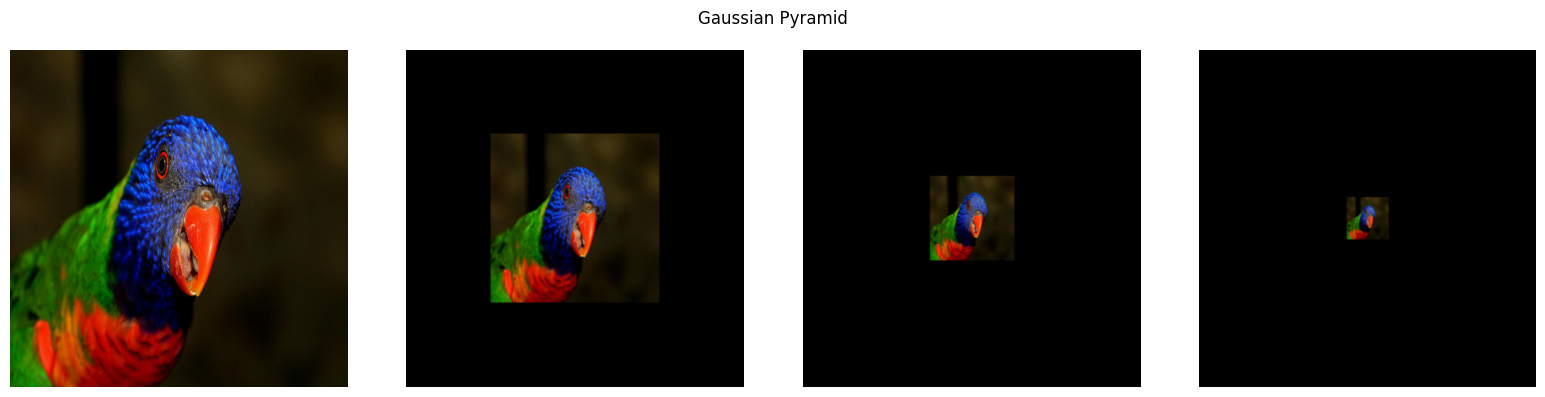

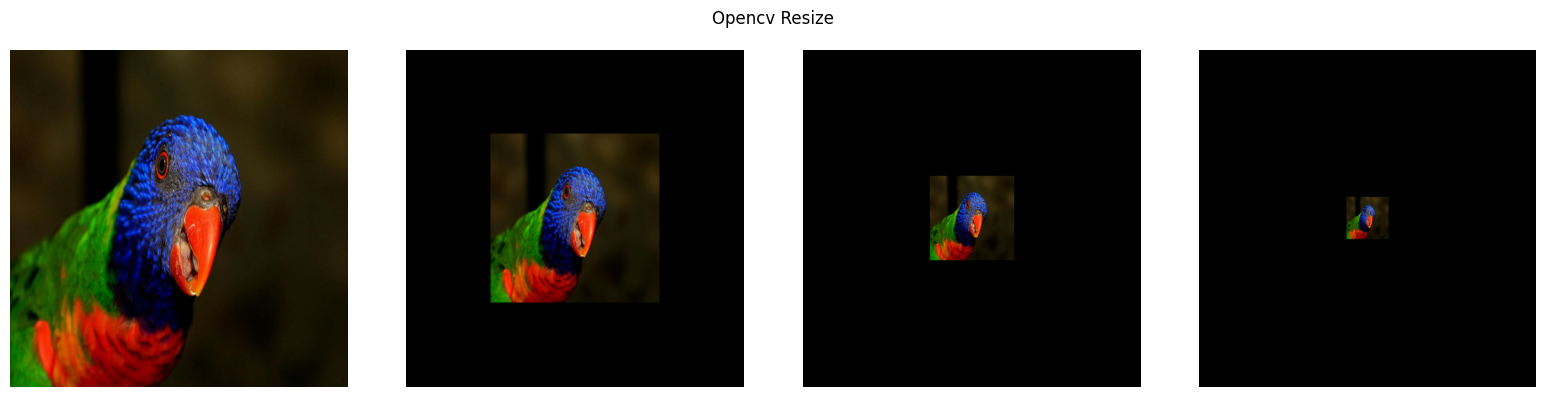

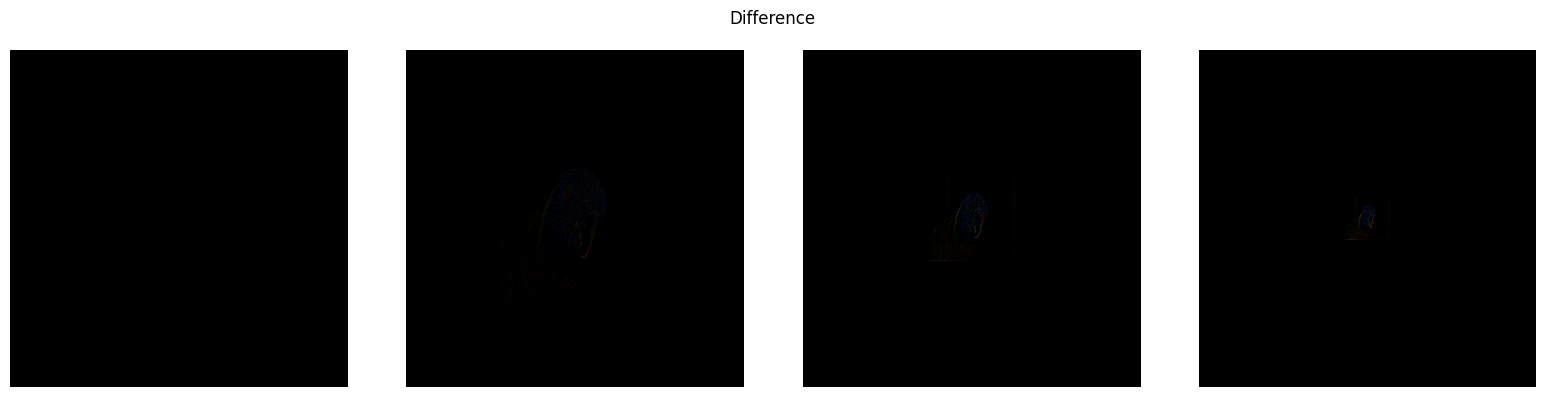

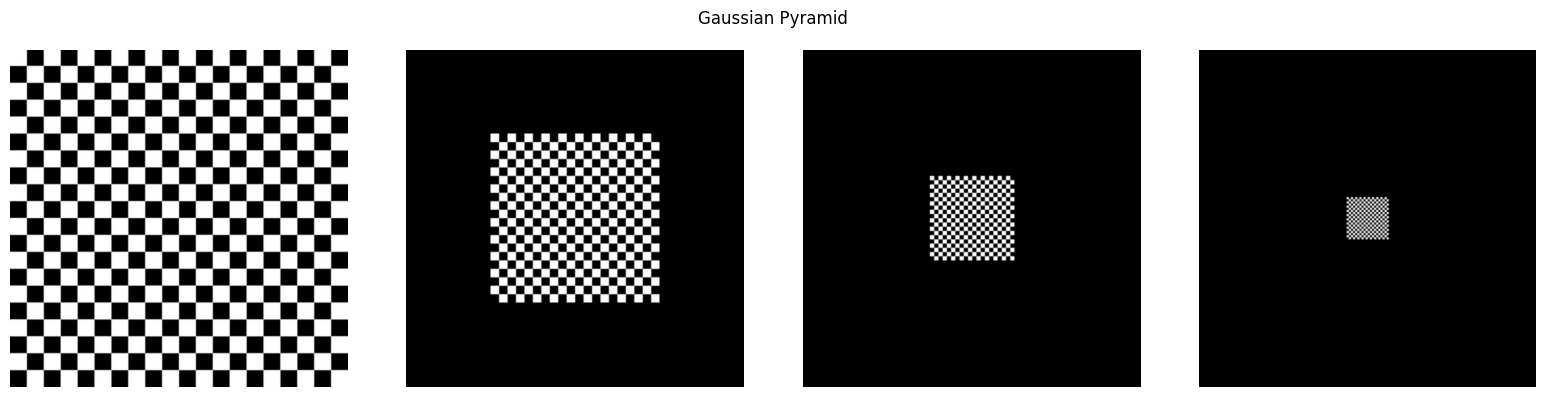

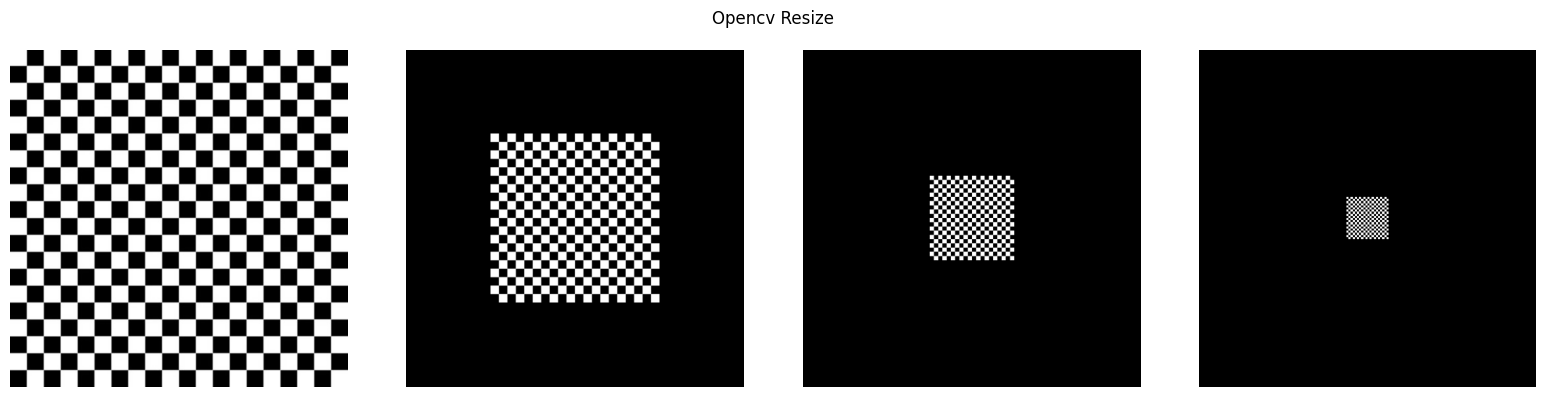

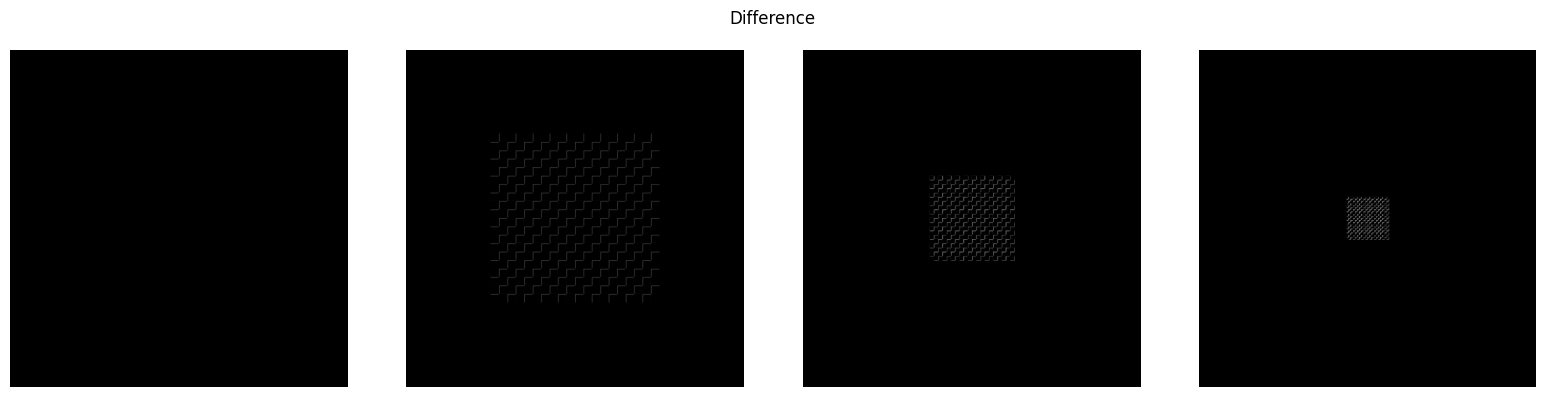

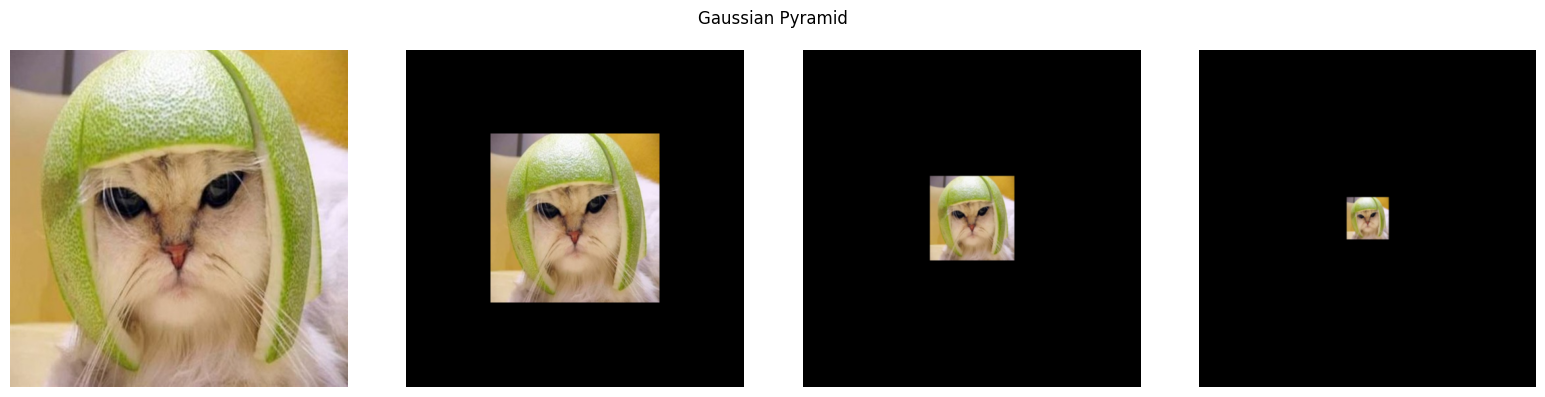

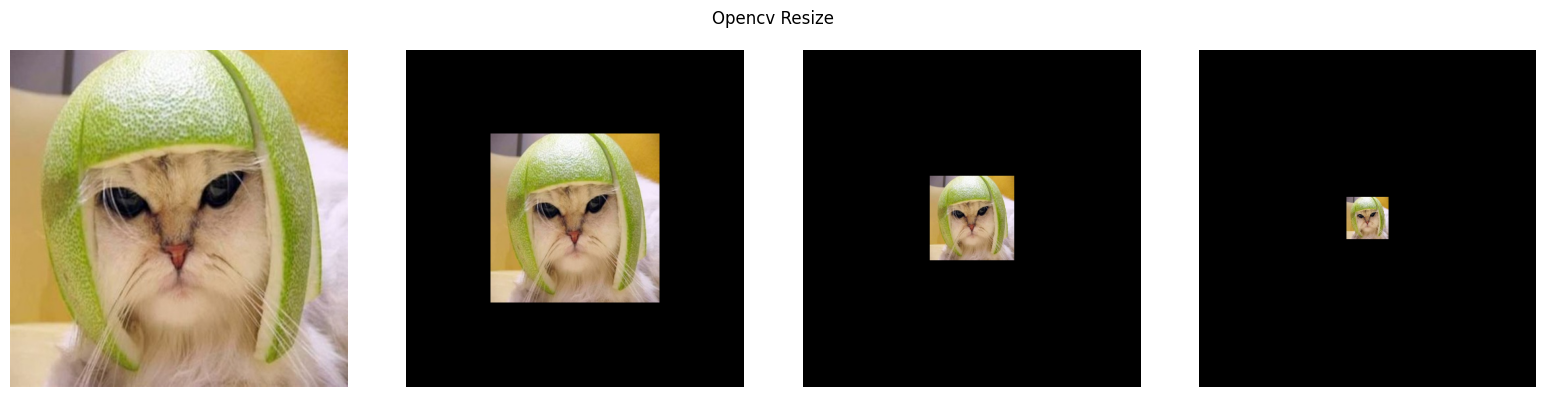

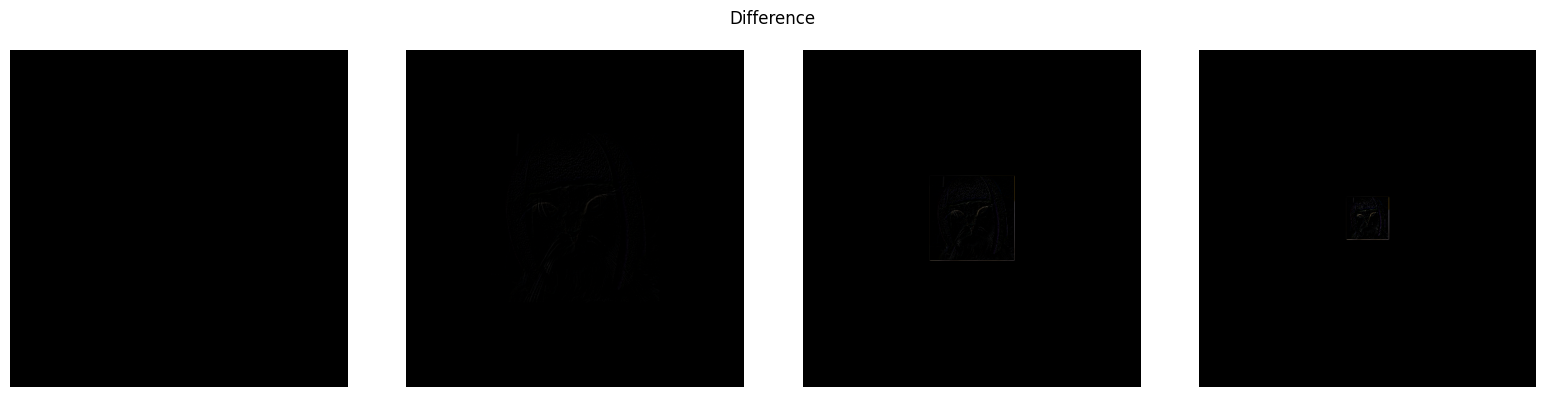

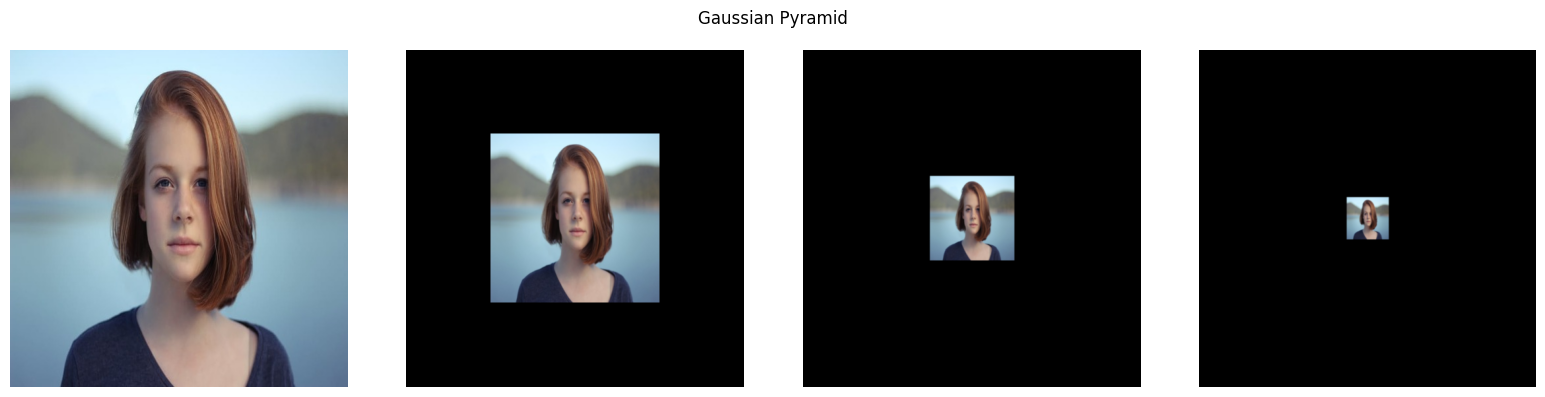

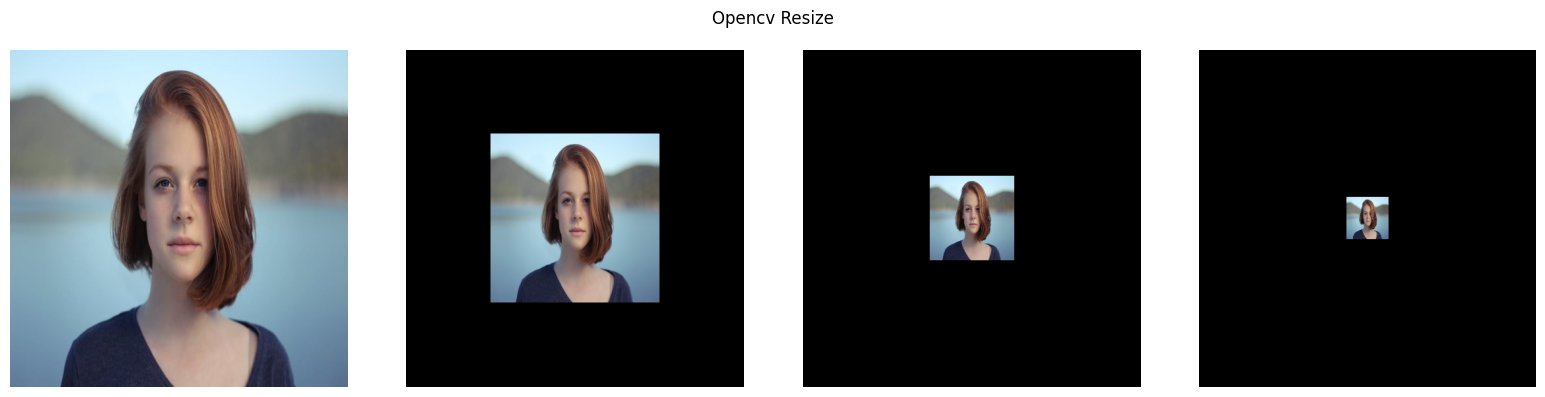

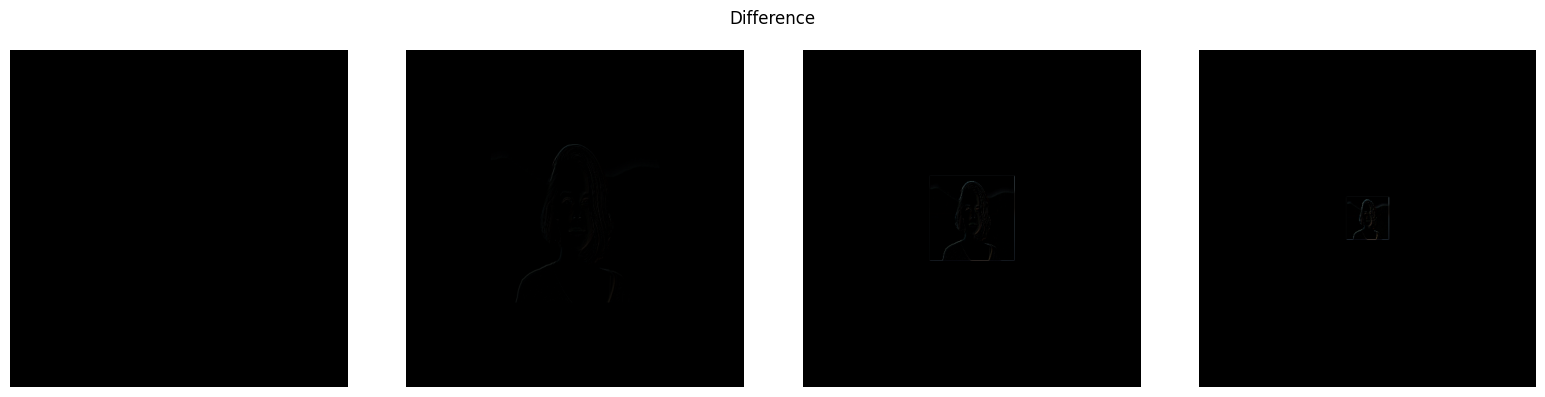

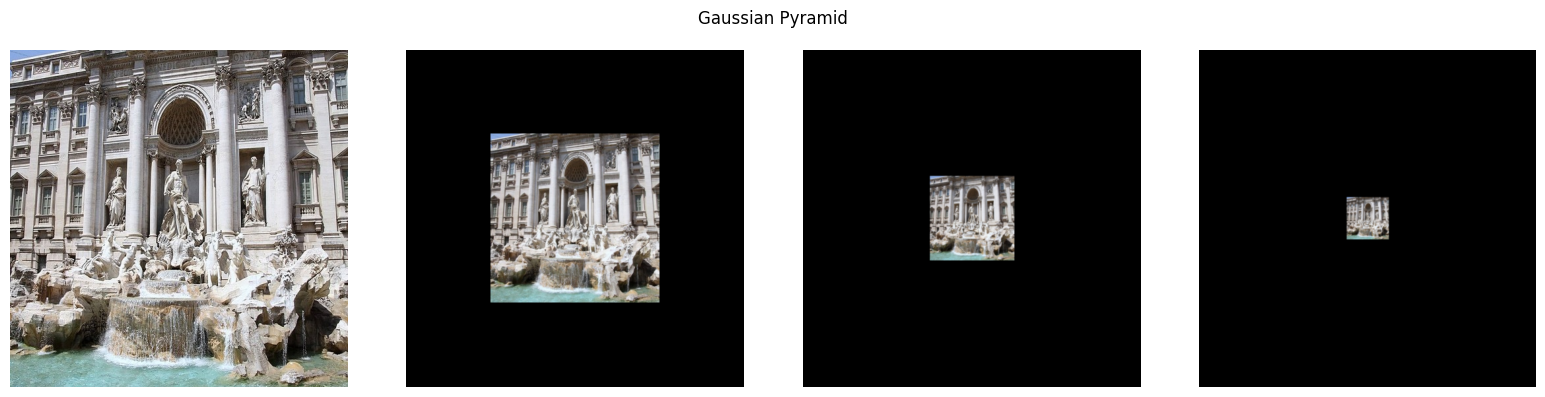

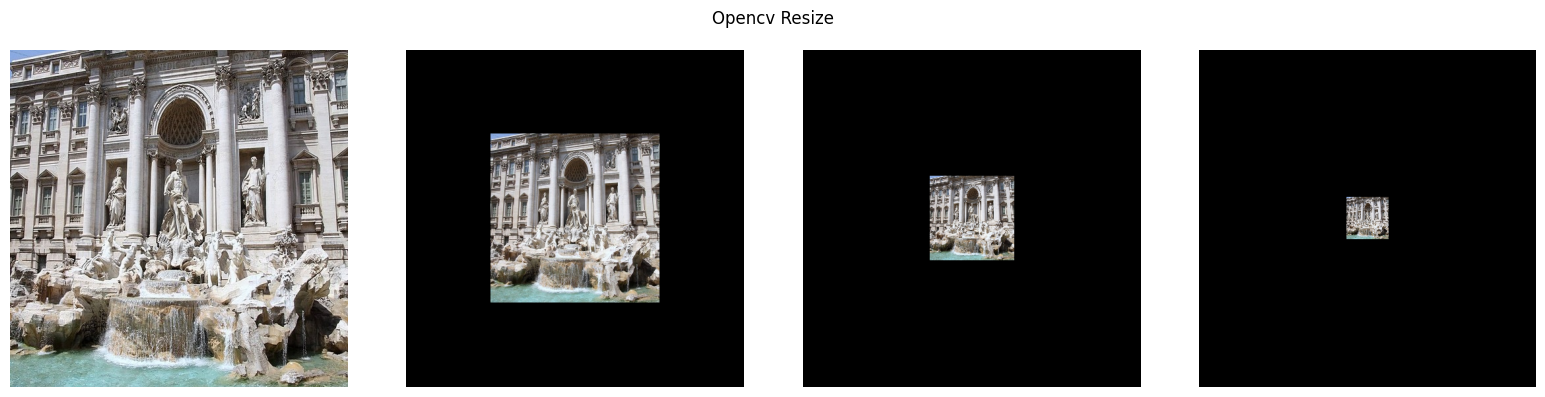

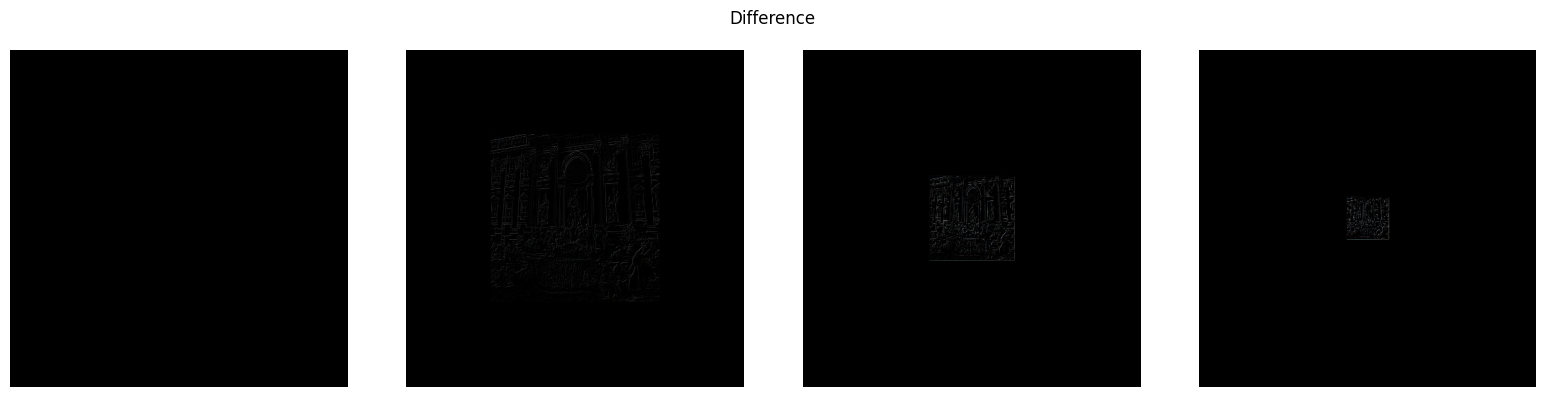

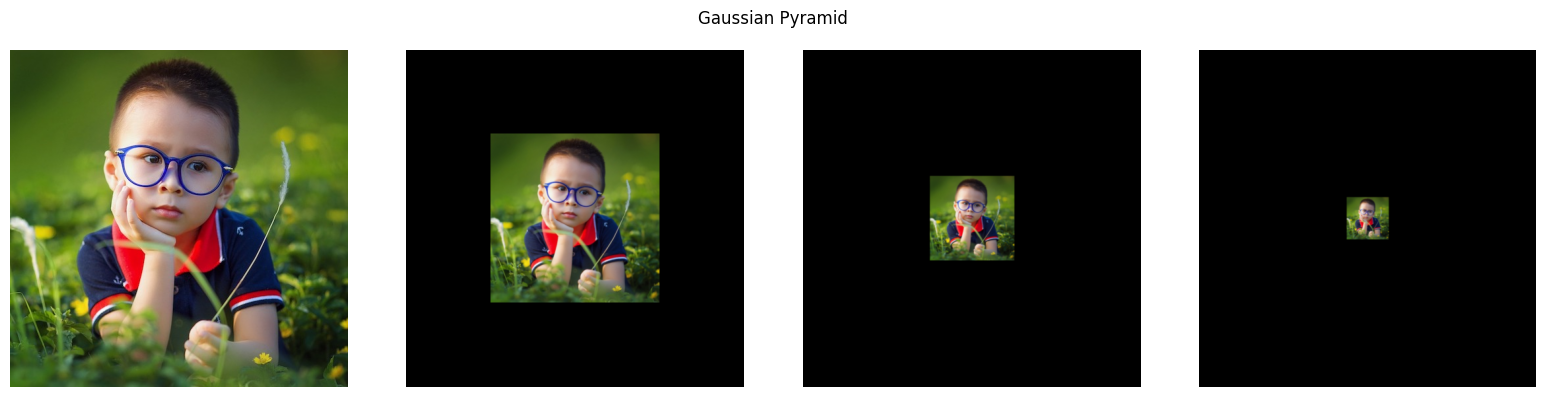

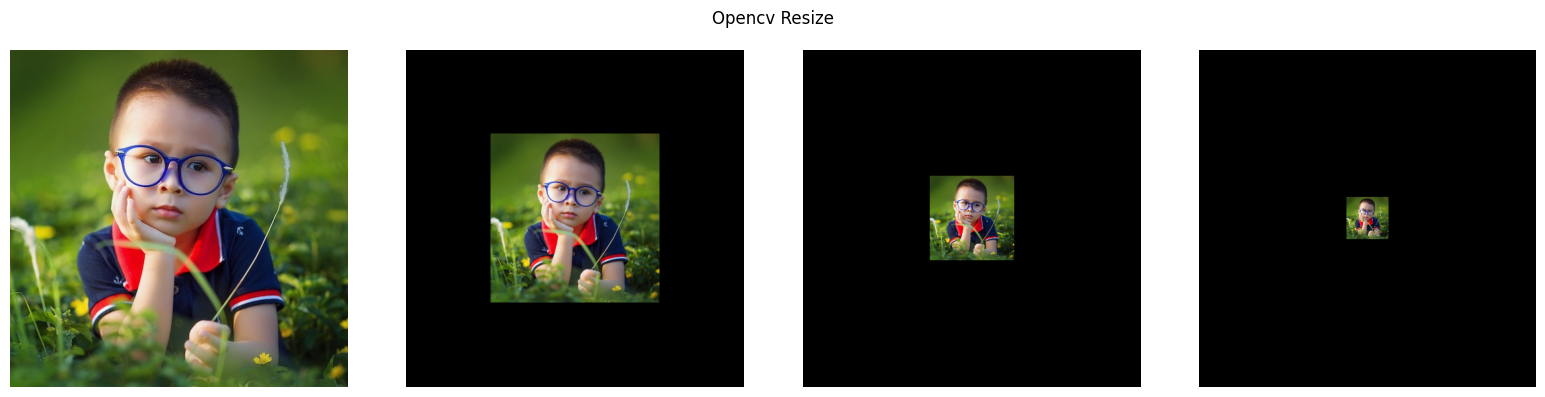

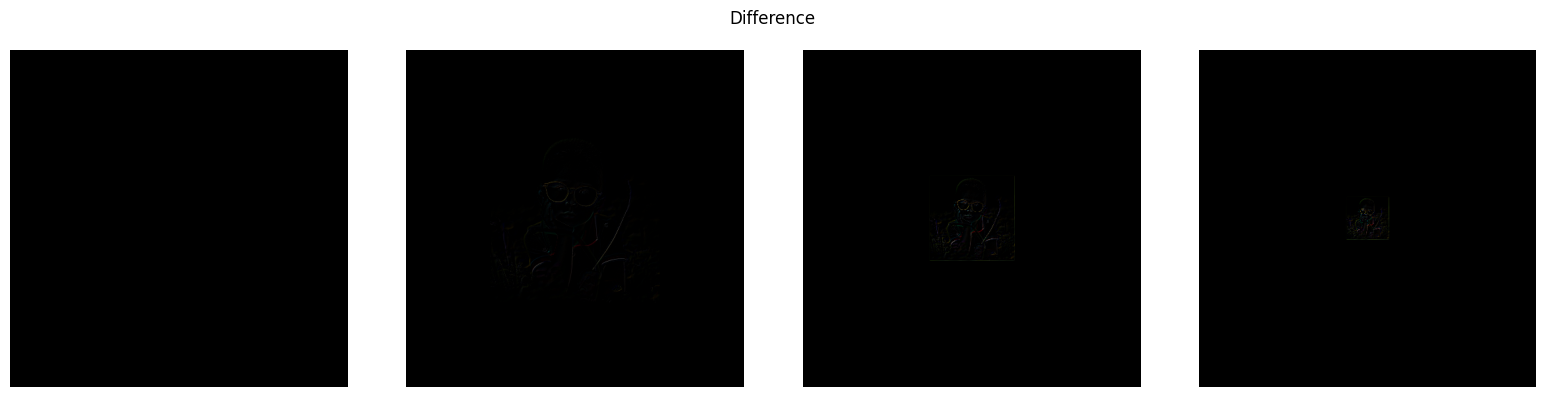

In [ ]:
for idx, image in enumerate(gt_images):

    # Generate pyramid of images for matching
    s_image_pyramids = build_gaussian_pyramid(image, levels=4)
    s_image_opecv_resize = opencv_resize(image, levels=4)

    diff = []
    for gauss_img, open_img in zip(s_image_pyramids, s_image_opecv_resize):
        diff.append(cv2.subtract(gauss_img, open_img))
    diff = np.array(diff)

    show_image_grid(s_image_pyramids, 1, 4, 'Gaussian Pyramid', figsize=16)
    show_image_grid(s_image_opecv_resize, 1, 4, 'Opencv Resize', figsize=16)
    show_image_grid(diff, 1, 4, 'Difference', figsize=16)

For normal images, there is no difference between our implementation and openCV's implementation. But for the checkerboard pattern, some difference is visible.

Implementation of image blending technique using Laplacian Pyramids from scratch.

In [ ]:
def build_gaussian_pyramid(image, levels):
    """Builds a Gaussian pyramid for the given image."""
    gaussian_pyramid = [image]
    for i in range(levels - 1):
        blurred = cv2.GaussianBlur(image, (5, 5), 1.0)
        downsampled = blurred[::2, ::2]  # Downsample by a factor of 2
        gaussian_pyramid.append(downsampled)
        image = downsampled
    return gaussian_pyramid

def build_laplacian_pyramid(gaussian_pyramid):
    """Builds a Laplacian pyramid from the given Gaussian pyramid."""
    laplacian_pyramid = []
    levels = len(gaussian_pyramid)

    for i in range(levels - 1):
        # Upsample the next level to the size of the current level
        next_level_upsampled = cv2.resize(gaussian_pyramid[i + 1], (gaussian_pyramid[i].shape[1], gaussian_pyramid[i].shape[0]))

        # Compute the Laplacian by subtracting the upsampled image from the current level
        laplacian = cv2.subtract(gaussian_pyramid[i], next_level_upsampled)
        laplacian_pyramid.append(laplacian)

    # The last level of the Laplacian pyramid is the same as the last level of the Gaussian pyramid
    laplacian_pyramid.append(gaussian_pyramid[-1])
    return laplacian_pyramid


def blend_pyramids(laplacianA, laplacianB, mask_pyramid):
    blended_pyramid = []
    for la, lb, mask in zip(laplacianA, laplacianB, mask_pyramid):
        # Expand mask dimensions to match image dimensions
        mask_expanded = np.expand_dims(mask, axis=-1)  # Add a new axis for the channel
        blended = la * (1 -mask_expanded) + lb * mask_expanded  # Blend using mask
        blended_pyramid.append(blended)
    return blended_pyramid

def reconstruct_from_laplacian_pyramid(laplacian_pyramid):
    """Reconstructs the image from the Laplacian pyramid."""
    image = laplacian_pyramid[-1]
    for i in range(len(laplacian_pyramid) - 2, -1, -1):
        # Upsample the image to the size of the next Laplacian level
        upsampled = cv2.resize(image, (laplacian_pyramid[i].shape[1], laplacian_pyramid[i].shape[0]))

        # Add the Laplacian to reconstruct the image
        image = cv2.add(upsampled, laplacian_pyramid[i])
    return image


def laplacian_pyramid_blend_images(image_a, image_b, levels=6, mask=None):
    if mask is None:
        # Create a binary mask for blending if none is provided
        rows, cols, _ = image_a.shape
        mask = np.zeros((rows, cols), dtype=np.float32)
        mask[:, cols // 2:] = 1  # Blend left and right halves

    # Generate Gaussian pyramids for both images and the mask
    gaussian_a = build_gaussian_pyramid(image_a, levels)
    gaussian_b = build_gaussian_pyramid(image_b, levels)
    gaussian_mask = build_gaussian_pyramid(mask, levels)

    # Generate Laplacian pyramids for both images
    laplacian_a = build_laplacian_pyramid(gaussian_a)
    laplacian_b = build_laplacian_pyramid(gaussian_b)

    # Blend the Laplacian pyramids
    blended_pyramid = blend_pyramids(laplacian_a, laplacian_b, gaussian_mask)

    # Reconstruct the final blended image
    blended_image = reconstruct_from_laplacian_pyramid(blended_pyramid)

    # Ensure the output image is in the valid range
    blended_image = np.clip(blended_image, 0, 255).astype(np.uint8)

    return blended_image

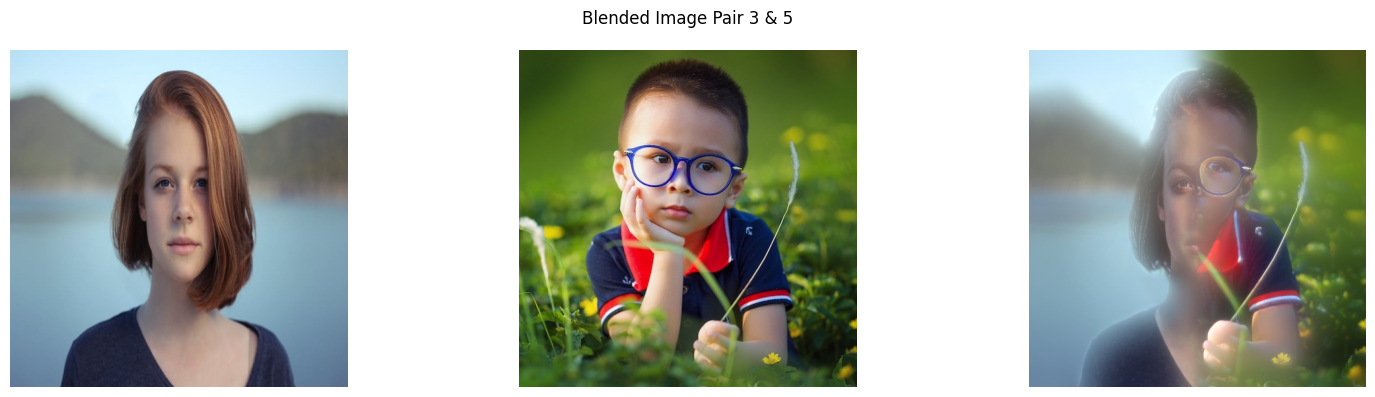

In [ ]:
blended_image = laplacian_pyramid_blend_images(gt_images[3], gt_images[5])
blended_image = np.clip(blended_image, 0, 255).astype(np.uint8)
collage = np.array([gt_images[3], gt_images[5], blended_image])
show_image_grid(collage, 1, 3, 'Blended Image Pair 3 & 5', figsize=16)

Implementation of Harris and Hessian Corner Detector algorithm from scratch.



The following is the implementation for the harris corner detection:

In [ ]:
def detect_harris_corner(image, k=0.04, threshold=1e-5):
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()


    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1],
                        [0, 0, 0],
                        [1, 2, 1]])

    I_x = convolve(gray.astype(np.float64), sobel_x)
    I_y = convolve(gray.astype(np.float64), sobel_y)


    I_x2 = I_x ** 2
    I_y2 = I_y ** 2
    I_xy = I_x * I_y

    # Calculating the sum of squares of the image derivatives (using low-pass filter)
    I_x2 = cv2.GaussianBlur(I_x2, (5, 5), 1)
    I_y2 = cv2.GaussianBlur(I_y2, (5, 5), 1)
    I_xy = cv2.GaussianBlur(I_xy, (5, 5), 1)

    # Compute the Harris response matrix R
    det_M = (I_x2 * I_y2) - (I_xy ** 2)
    trace_M = I_x2 + I_y2
    R = det_M - k * (trace_M ** 2)

    # Threshold the response and find corners
    corners = np.zeros_like(R)
    corners[R > threshold * R.max()] = 255

    return corners.astype(np.uint8)

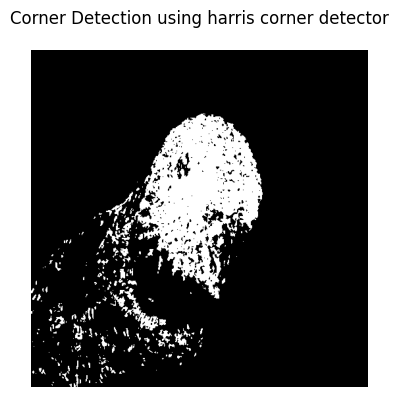

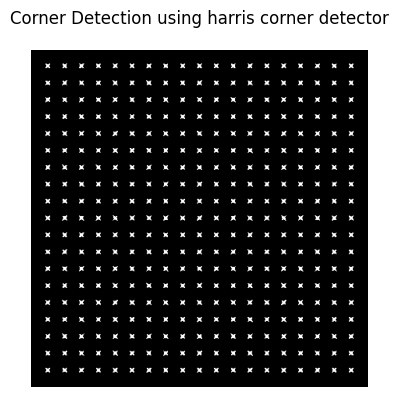

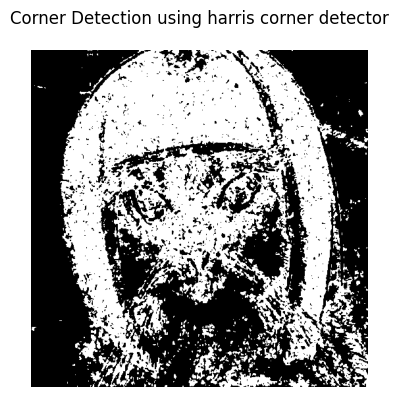

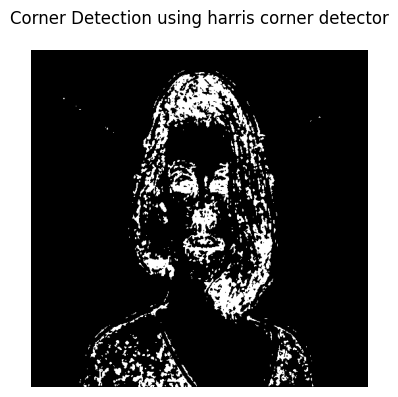

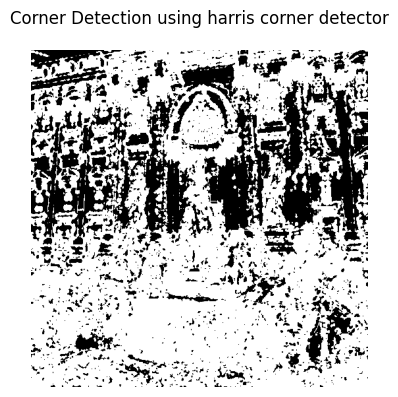

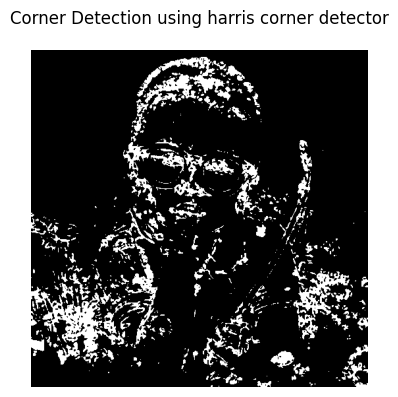

In [ ]:
for image in gt_images:
    corner_image = detect_harris_corner(image)
    show_image_grid(corner_image, 1, 1, 'Corner Detection using harris corner detector', figsize=16)

The Hessian corner detection is implemented a bit differently.

In [ ]:
def hessian_corner_detector(image, threshold=1e-5):
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()

    # Compute second-order derivatives using convolution
    kernel_xx = np.array([[1, -2, 1],
                          [2, -4, 2],
                          [1, -2, 1]])
    kernel_yy = kernel_xx.T

    kernel_xy = np.array([[-1, 0, 1],
                          [0, 0, 0],
                          [1, 0, -1]])

    I_xx = convolve(gray.astype(np.float64), kernel_xx)
    I_yy = convolve(gray.astype(np.float64), kernel_yy)
    I_xy = convolve(gray.astype(np.float64), kernel_xy)


    det_H = I_xx * I_yy - I_xy ** 2
    trace_H = I_xx + I_yy

    # Compute the Hessian response
    response = det_H / (trace_H + 1e-10)  # Avoid division by zero

    # Threshold the response and find corners
    corners = np.zeros_like(response)
    corners[response > threshold * response.max()] = 255

    return corners.astype(np.uint8)

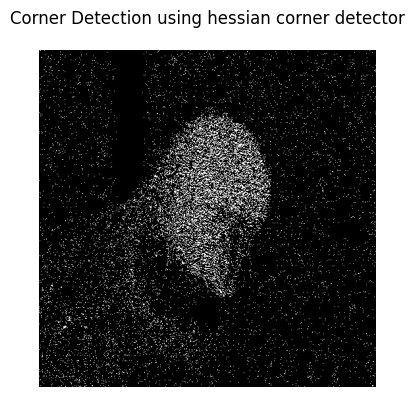

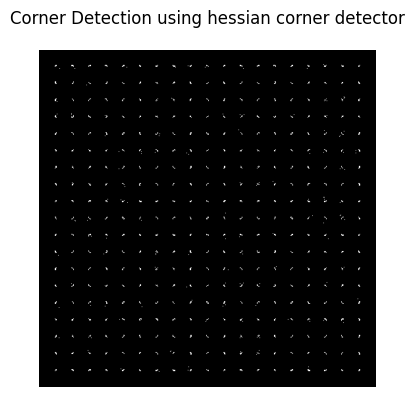

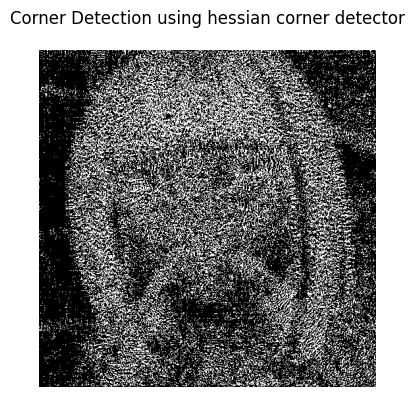

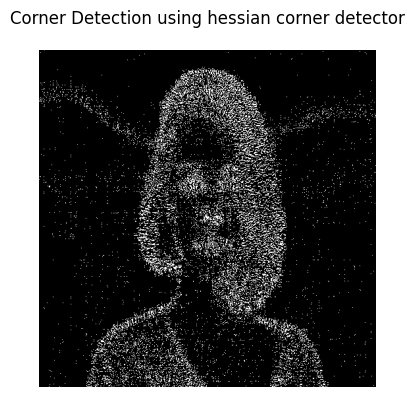

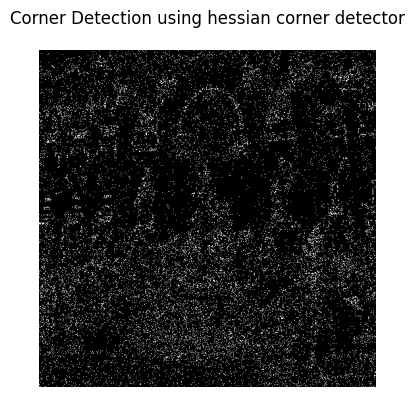

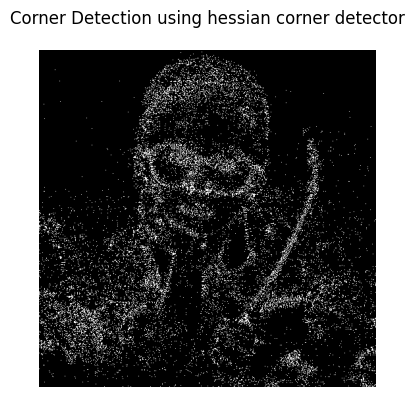

In [ ]:
for image in gt_images:
    corner_image = hessian_corner_detector(image, 0.001)
    show_image_grid(corner_image, 1, 1, 'Corner Detection using hessian corner detector', figsize=16)